In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import sys, os
import warnings
warnings.filterwarnings("ignore")

# Os path
script_dir  = os.path.normpath(os.path.abspath("."))
source_dir  = os.path.normpath(os.path.abspath(script_dir + "/.."))
if source_dir in sys.path: sys.path.remove(source_dir)
sys.path.insert(1, source_dir)

%matplotlib inline

# Data path and load data
test_data_dir = r'/media/nghia/DATA/DATA/RRT_CNU_ENG/Processed/Test_all_cleaned/'
test_data = pd.read_csv(test_data_dir + 'test_all_cleaned_labelled.csv')

# Features list definition

In [2]:
# patient id list
id_list = [x for x in test_data.columns if x in ['alternative number']]

################# Features selection - you can customize input features list but should be match with training data #################
# Laboratory test
lab_list = ['pO2', 'Potassium(K+)', 'Alkaline phosphatase' ,'pCO2', 'CRP' ,'CRP2', 'pH',
 'Albumin', 'Total protein', 'PT', 'Sodium', 'WBC', 'AST', 'Hgb', 'BUN', 'aPTT',
 'Chloride', 'Plt', 'Total calcium', 'SaO2', 'ALT', 'Creatinin',
 'Total bilirubin', 'Glucose', 'HCO3', 'Lactate']

# Vital sign
sign_list = ['HR', 'SBP', 'DBP', 'RR', 'BT']

# Demographic information - defined non-time based list
dem_list = ['Diagnosis', 'age', 'gender', 'hospitalization department', 'hospitalization route', 'inpatient ward']


# define time based list
time_list = lab_list + sign_list

#########################################################

# label list
label_abn_list = [x for x in test_data.columns if x in ['label']]
label_dec_list = [x for x in test_data.columns if x in ['is_detection']]
label_event_list = [x for x in test_data.columns if x in ['is_event']]
label_event_w_dec_list = [x for x in test_data.columns if x in ['ev_w_dec']]

In [3]:
# Window pre-processing

from dataloader import *

x_t, x_d, y_dec, y_dec_onehot = ts_dataloader(test_data, time_list, dem_list, window_len=8,
                                              scaler=8, stride=8, task='detection')

100%|██████████| 6859/6859 [04:44<00:00, 24.12it/s]


# Get prediction

In [4]:
from model import *

model = SiamseTS_model(x_t.shape[1:], x_d.shape[1:], num_classes=2)

2024-01-03 17:01:35.442014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 17:01:36.024173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-03 17:01:36.024231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-03 17:01:36.024236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [5]:
# load trained model
model_path = r'/media/nghia/DATA/DATA/RRT_CNU_ENG/Intergatrate_model/Detection/MGTS_88/best_model_12301520.hdf5'
model.load_weights(model_path)

In [6]:
# get prediction
keras.backend.clear_session()
with tf.device('/cpu:0'):
    y_pred = model.predict([x_t, x_d])

6030/6030 [==============================] - 11s 2ms/step


In [7]:
y_prob = y_pred[:,1] # probability of detection
y_label = np.argmax(y_pred, axis=1) # label of detection

# Evaluation

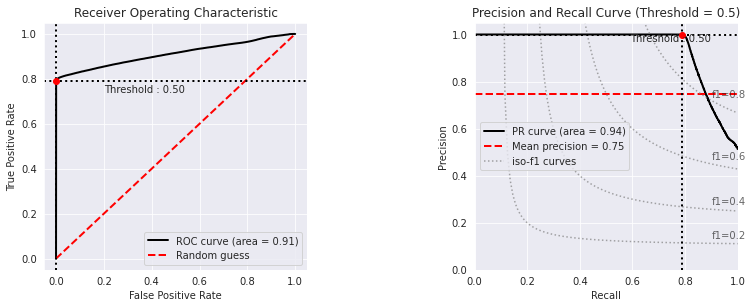

f1 score 0.6978:
f2 score 0.6344:
precision 0.9989:
recall 0.7944:
AUPRC 0.9494:
AUROC 0.8967:
Acc 0.8940:
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
               precision    recall  f1-score   support

Non-Detection       0.82      1.00      0.90     93916
    Detection       1.00      0.79      0.88     99036

     accuracy                           0.89    192952
    macro avg       0.91      0.89      0.89    192952
 weighted avg       0.91      0.89      0.89    192952



In [8]:
from eval import *

Evaluation(y_dec, y_prob, y_label, labels=['Non-Detection', 'Detection'])